
# Preparations

In [1]:
import Pkg
Pkg.DEFAULT_IO[] = stdout;

### Fetches Packages

In [2]:
using Revise, ForwardDiff, Parameters, Setfield, Plots, LinearAlgebra
using DifferentialEquations
using BifurcationKit
using Statistics
const BK = BifurcationKit

# sup norm
norminf(x) = norm(x, Inf);

┌ Info: Precompiling Setfield [efcf1570-3423-57d1-acb7-fd33fddbac46]
└ @ Base loading.jl:1423
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423
┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1423
┌ Info: Precompiling BifurcationKit [0f109fa4-8a5d-4b75-95aa-f515264e7665]
└ @ Base loading.jl:1423


#### Fetch General Project Files


In [3]:
include("../../Codebase/Functions/file_managment_functions.jl");

### Declares the model

In [4]:
function sigBModel!(dz, z, p, t)
    kBw, kDw, kD, kB1, kB2, kB3, kB4, kB5, kD1, kD2, kD3, kD4, kD5, kK1, kK2, kP, kDeg, v0, F, K, λW, λV, pInit, pStress, η = p
    w, w2, w2v, v, w2v2, vP, σB, w2σB, vPp, phos = z

    dz[1] = (v0*λW*(1 + F*σB)) / (K + σB) + 2kDw*w2 - kBw*(w^2) - kDeg*w
    dz[2] = kD1*w2v + kK1*w2v + kD3*w2σB + (1//2)*kBw*(w^2) - kDeg*w2 - kDw*w2 - kB1*v*w2 - kB3*w2*σB
    dz[3] = kD2*w2v2 + kK2*w2v2 + kB1*v*w2 + kB4*v*w2σB - kD1*w2v - kDeg*w2v - kK1*w2v - kB2*v*w2v - kD4*w2v*σB
    dz[4] = kD1*w2v + kD2*w2v2 + kP*vPp + (v0*λV*(1 + F*σB)) / (K + σB) + kD4*w2v*σB - kDeg*v - kB1*v*w2 - kB2*v*w2v - kB4*v*w2σB
    dz[5] = kB2*v*w2v - kD2*w2v2 - kDeg*w2v2 - kK2*w2v2
    dz[6] = kD5*vPp + kK1*w2v + kK2*w2v2 + vPp - kDeg*vP - kB5*phos*vP
    dz[7] = kD3*w2σB + (v0*(1 + F*σB)) / (K + σB) + kB4*v*w2σB - kDeg*σB - kB3*w2*σB - kD4*w2v*σB
    dz[8] = kB3*w2*σB + kD4*w2v*σB - kD3*w2σB - kDeg*w2σB - kB4*v*w2σB
    dz[9] = kB5*phos*vP - vPp - kD5*vPp - kDeg*vPp - kP*vPp
    dz[10] = pStress + kD5*vPp + kDeg*vPp + kP*vPp - phos - kB5*phos*vP
    dz
end
sigBModel = (z, p) -> sigBModel!(similar(z), z, p, 0);
p_syms = [:kBw, :kDw, :kD, :kB1, :kB2, :kB3, :kB4, :kB5, :kD1, :kD2, :kD3, :kD4, :kD5, :kK1, :kK2, :kP, :kDeg, :v0, :F, :K, :λW, :λV, :pInit, :pStress, :η]
p_vals_org = [3600.0, 18.0, 18.0, 3600.0, 3600.0, 3600.0, 1800.0, 3600.0, 18.0, 18.0, 18.0, 1800.0, 18.0, 36.0, 36.0, 180.0, 0.7, 0.4, 30.0, 0.2, 4.0, 4.5, 0.001, 0.4, 0.05];

In [5]:
get_p_idx(p_sym) = findfirst(p_syms .== p_sym)
function get_p_vals(target_p,p_span,p_changes=[])
    p_vals = deepcopy(p_vals_org)
    foreach(pc -> p_vals[get_p_idx(pc[1])]=pc[2], [p_changes;target_p=>p_span[1]])
    return p_vals
end
get_pars(p_vals) = (kBw=p_vals[1],kDw=p_vals[2],kD=p_vals[3],kB1=p_vals[4],kB2=p_vals[5],kB3=p_vals[6],kB4=p_vals[7],kB5=p_vals[8],kD1=p_vals[9],kD2=p_vals[10],kD3=p_vals[11],kD4=p_vals[12],kD5=p_vals[13],kK1=p_vals[14],kK2=p_vals[15],kP=p_vals[16],kDeg=p_vals[17],v0=p_vals[18],F=p_vals[19],K=p_vals[20],λW=p_vals[21],λV=p_vals[22],pInit=p_vals[23],pStress=p_vals[24],η=p_vals[25]);
get_z0(p_vals) = solve(ODEProblem(sigBModel!,fill(1.0,10),(0.,50.0),p_vals), Rosenbrock23()).u[end];
get_bProb_kK2(p_vals) = BifurcationProblem(sigBModel, get_z0(p_vals), get_pars(p_vals), (@lens _.kK2); recordFromSolution = (x, p) -> x[7]);
get_bProb_λV(p_vals) = BifurcationProblem(sigBModel, get_z0(p_vals), get_pars(p_vals), (@lens _.λV); recordFromSolution = (x, p) -> x[7]);
get_bProb_pStress(p_vals) = BifurcationProblem(sigBModel, get_z0(p_vals), get_pars(p_vals), (@lens _.pStress); recordFromSolution = (x, p) -> x[7]);

### Plotting Functions

In [6]:
select_bps(cont,idxs) = map(idx -> cont.specialpoint[idx], idxs);
function split_branch(branch,starts,ends)
    return map(i -> branch.branch[starts[i]:ends[i]], 1:length(starts))
end
function plot_bp!(bp,idx,color;kwargs...)
    scatter!((bp.branch[idx].param,bp.branch[idx].x);color=color,label="",kwargs...)
end
function plot_bp_po!(bp,idx,color;kwargs...)
    scatter!((bp.branch[idx].param,bp.branch[idx].max);color=color,label="",kwargs...)
    scatter!((bp.branch[idx].param,bp.branch[idx].min);color=color,label="",kwargs...)
end
function plot_po!(branch;kwargs...)
    plot!(getfield.(branch,:param),getfield.(branch,:min); label="", kwargs...)
    plot!(getfield.(branch,:param),getfield.(branch,:max); label="", kwargs...)
end
function plot_branch!(branch;cS=:blue,cU=:red,kwargs...)
    stab = mean(getfield.(branch,:stable))>0.5
    plot!(getfield.(branch,:param),getfield.(branch,:x); label="", kwargs...)
end;

In [7]:
function make_po_args_kK2(p_vals)
    pars = get_pars(p_vals)
    return (recordFromSolution = (x, p) -> begin
        xtt = BK.getPeriodicOrbit(p.prob, x, @set pars.kK2 = p.p)
        return (max = maximum(xtt[7,:]),
                min = minimum(xtt[7,:]),
                period = getPeriod(p.prob, x, @set pars.kK2 = p.p))
    end,
    plotSolution = (x, p; k...) -> begin
            xtt = BK.getPeriodicOrbit(p.prob, x, @set pars.kK2 = p.p)
            plot!(xtt.t, xtt.u[7,:]; label = "X", k...)
            plot!(br; subplot = 1, putspecialptlegend = false)
        end,
    normC = norminf);
end
function make_po_args_λV(p_vals)
    pars = get_pars(p_vals)
    return (recordFromSolution = (x, p) -> begin
        xtt = BK.getPeriodicOrbit(p.prob, x, @set pars.λV = p.p)
        return (max = maximum(xtt[7,:]),
                min = minimum(xtt[7,:]),
                period = getPeriod(p.prob, x, @set pars.λV = p.p))
    end,
    plotSolution = (x, p; k...) -> begin
            xtt = BK.getPeriodicOrbit(p.prob, x, @set pars.λV = p.p)
            plot!(xtt.t, xtt.u[7,:]; label = "X", k...)
            plot!(br; subplot = 1, putspecialptlegend = false)
        end,
    normC = norminf);
end;

### Plot settings

In [8]:
starsize = 20; 
starstrokewidth = 2;
ms = 11
lw = 10 
la = 0.9;

In [9]:
gr(); 
mm = Plots.mm
default(fmt = :png,framestyle=:box,grid=false,xguidefontsize=16,yguidefontsize=16,titlefontsize=18);

### Bifurcation options

In [10]:
optn_po = NewtonPar(verbose=false, tol=1e-8,  maxIter=10);

# Analysis

## Supplementary Bifurcation diagrams

#### Bifurcation diagram 1

In [11]:
p_span_1 = (3.6,360.0);
p_vals_1 = get_p_vals(:kK2,p_span_1,[:pStress=>0.8]);

In [12]:
opts_br_1 = ContinuationPar(pMin=p_span_1[1], pMax=p_span_1[2], ds=0.005, dsmax=0.05, maxSteps = 10000, detectBifurcation=3, nInversion=8, maxBisectionSteps=25, nev=4);
opts_po_1 = ContinuationPar(pMin=p_span_1[1], pMax=p_span_1[2], dsmin=0.0001, ds=-0.01, dsmax=0.02, maxSteps=1000, newtonOptions=(@set optn_po.tol=1e-9), nev=4, tolStability=1.0, detectBifurcation=2, plotEveryStep=10, saveSolEveryStep=1);

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1423


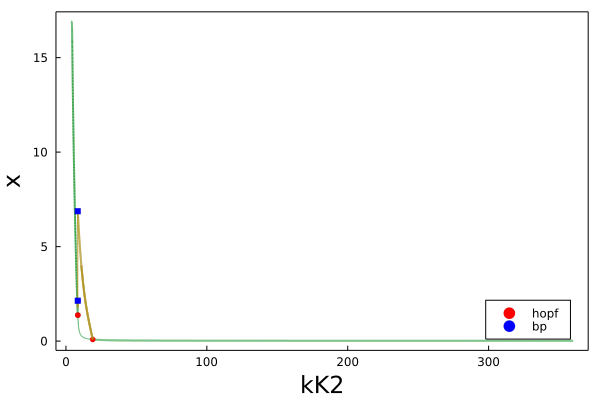

In [13]:
br_1 = continuation(get_bProb_kK2(p_vals_1), PALC(tangent=Bordered()), opts_br_1; plot=false, normC=norminf);
br_po_1 = continuation(br_1, 1, opts_po_1, PeriodicOrbitTrapProblem(M=200, jacobian=:Dense, updateSectionEveryStep=1); verbosity=0, callback=BK.cbMaxNorm(10), plot=false, make_po_args_kK2(p_vals_1)...).γ;
plot(br_1,br_po_1, legend=:bottomright)

In [14]:
bps_1 = select_bps(br_1,[1,2])
starts_1 = [1,bps_1[1].idx,bps_1[2].idx]
ends_1 = [bps_1[1].idx,bps_1[2].idx,length(br_1.branch)]
branches_1 = split_branch(br_1,starts_1,ends_1);

plot(); 
plot_branch!(branches_1[1];lw=lw,la=la,color=:blue,linestyle=:solid)
plot_branch!(branches_1[2];lw=lw,la=la,color=:red,linestyle=:dot)
plot_branch!(branches_1[3];lw=lw,la=la,color=:blue,linestyle=:solid)

bps_po_1 = select_bps(br_po_1,[1,2,3])
starts_po_1 = [1,122]
ends_po_1 = [122,668]
branches_po_1 = split_branch(br_po_1,starts_po_1,ends_po_1);

plot_po!(branches_po_1[1];lw=lw,la=la,color=:purple,linestyle=:dot)
plot_po!(branches_po_1[2];lw=lw,la=la,color=:purple,linestyle=:solid)

plot_bp!(br_1, bps_1[1].idx, :red; ms=ms)
plot_bp!(br_1, bps_1[2].idx, :red; ms=ms)
plot_bp_po!(br_po_1, bps_po_1[2].idx, :yellow; ms=ms)
bif_dia_1_plot = plot!(xlimit=(p_span_1[1],p_span_1[2]),xaxis=:log10)

idx = findfirst(getfield.(br_1.branch,:param) .> 36.0)
scatter!((br_1.branch[idx].param,br_1.branch[idx].x),markercolor=:lightgreen, markersize=starsize, markerstrokewidth=starstrokewidth, markershape=:star4,label="",ylimit=(-1.2,20.0));

#### Bifurcation diagram 2

In [15]:
p_span_2 = (0.45,45.0);
p_vals_2 = get_p_vals(:λV,p_span_2,[:pStress=>0.05]);

In [16]:
opts_br_2 = ContinuationPar(pMin=p_span_2[1], pMax=p_span_2[2], ds=0.005, dsmax=0.05, maxSteps = 3500, detectBifurcation=3, nInversion=8, maxBisectionSteps=25, nev=4);
opts_po_2 = ContinuationPar(pMin=p_span_2[1], pMax=p_span_2[2], dsmin=0.0025, ds=-0.1, dsmax=0.5, maxSteps=200, newtonOptions=(@set optn_po.tol=1e-8), nev=10, tolStability=1e-1, detectBifurcation=2, plotEveryStep=10, saveSolEveryStep=1);

┌ Warning: Error in eigenvalues computation. It seems that an eigenvalue is missing, probably conj(λ) for some already computed eigenvalue λ. This makes the identification (but not the detection) of bifurcation points erroneous. You should increase the number of requested eigenvalues `nev`.
└ @ BifurcationKit /home/SLCU/torkel.loman/.julia/packages/BifurcationKit/fnCOr/src/Bifurcations.jl:110
┌ Warning: Error in eigenvalues computation. It seems that an eigenvalue is missing, probably conj(λ) for some already computed eigenvalue λ. This makes the identification (but not the detection) of bifurcation points erroneous. You should increase the number of requested eigenvalues `nev`.
└ @ BifurcationKit /home/SLCU/torkel.loman/.julia/packages/BifurcationKit/fnCOr/src/Bifurcations.jl:110
┌ Warning: Error in eigenvalues computation. It seems that an eigenvalue is missing, probably conj(λ) for some already computed eigenvalue λ. This makes the identification (but not the detection) of bifurcati

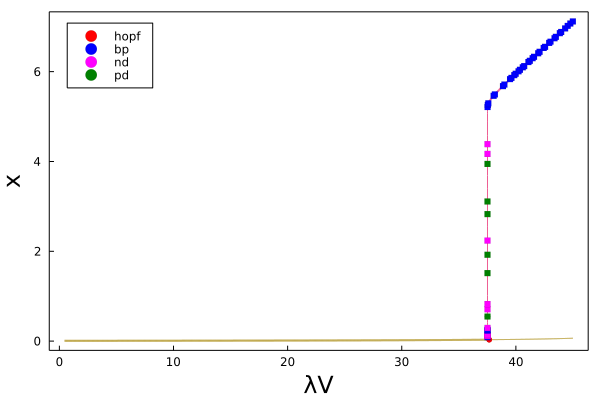

In [17]:
br_2 = continuation(get_bProb_λV(p_vals_2), PALC(tangent=Bordered()), opts_br_2; plot=false, normC=norminf);
br_po_2 = continuation(br_2, 1, opts_po_2, PeriodicOrbitTrapProblem(M=200, jacobian=:Dense, updateSectionEveryStep=1); verbosity=0, callback=BK.cbMaxNorm(10), plot=false, make_po_args_λV(p_vals_2)...).γ;
plot(br_2,br_po_2, legend=:topleft)

In [18]:
bps_2 = select_bps(br_2,[1])
starts_2 = [1,bps_2[1].idx]
ends_2 = [bps_2[1].idx,length(br_2.branch)]
branches_2 = split_branch(br_2,starts_2,ends_2);

plot(); 
plot_branch!(branches_2[1];lw=lw,la=la,color=:blue,linestyle=:solid)
plot_branch!(branches_2[2];lw=lw,la=la,color=:red,linestyle=:dot)

starts_po_2 = [1,58]
ends_po_2 = [58,length(br_po_2.branch)]
branches_po_2 = split_branch(br_po_2,starts_po_2,ends_po_2);

plot_po!(branches_po_2[1];lw=lw,la=la,color=:purple,linestyle=:dot)
plot_po!(branches_po_2[2];lw=lw,la=la,color=:purple,linestyle=:solid)

plot_bp!(br_2, bps_2[1].idx, :red; ms=ms)
plot_bp_po!(br_po_2, 58, :yellow; ms=ms)
bif_dia_2_plot = plot!(xlimit=(p_span_2[1],p_span_2[2]),yaxis=:log10)

idx = findfirst(getfield.(br_2.branch,:param) .> 4.5)
scatter!((br_2.branch[idx].param,br_2.branch[idx].x),markercolor=:lightgreen, markersize=starsize, markerstrokewidth=starstrokewidth, markershape=:star4,label="",ylimit=(1e-3,1e1));

#### Bifurcation diagram 3

In [19]:
p_span_3 = (0.45,45.0);
p_vals_3 = get_p_vals(:λV,p_span_3,[:pStress=>0.20]);

In [20]:
opts_br_3 = ContinuationPar(pMin=p_span_3[1], pMax=p_span_3[2], ds=0.005, dsmax=0.05, maxSteps = 3500, detectBifurcation=3, nInversion=8, maxBisectionSteps=25, nev=10);
opts_po_3 = ContinuationPar(pMin=p_span_3[1], pMax=p_span_3[2], dsmin=0.0025, ds=-0.1, dsmax=0.5, maxSteps=200, newtonOptions=(@set optn_po.tol=1e-8), nev=10, tolStability=1e-1, detectBifurcation=2, plotEveryStep=10, saveSolEveryStep=1);

┌ Warning: Error in eigenvalues computation. It seems that an eigenvalue is missing, probably conj(λ) for some already computed eigenvalue λ. This makes the identification (but not the detection) of bifurcation points erroneous. You should increase the number of requested eigenvalues `nev`.
└ @ BifurcationKit /home/SLCU/torkel.loman/.julia/packages/BifurcationKit/fnCOr/src/Bifurcations.jl:110


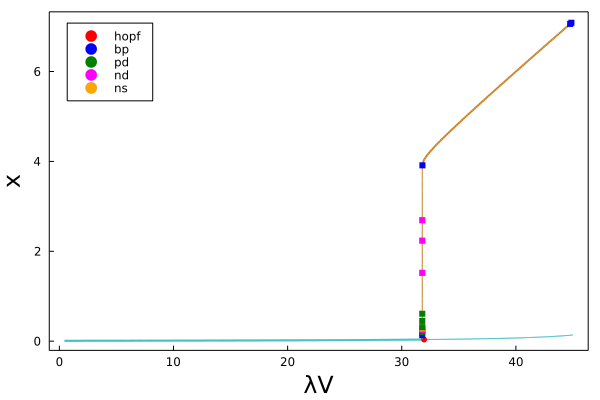

In [21]:
br_3 = continuation(get_bProb_λV(p_vals_3), PALC(tangent=Bordered()), opts_br_3; plot=false, normC=norminf);
br_po_3 = continuation(br_3, 1, opts_po_3, PeriodicOrbitTrapProblem(M=200, jacobian=:Dense, updateSectionEveryStep=1); verbosity=0, callback=BK.cbMaxNorm(10), plot=false, make_po_args_λV(p_vals_3)...).γ;
plot(br_3,br_po_3, legend=:topleft)

In [22]:
bps_3 = select_bps(br_3,[1])
starts_3 = [1,bps_3[1].idx]
ends_3 = [bps_3[1].idx,length(br_3.branch)]
branches_3 = split_branch(br_3,starts_3,ends_3);

plot(); 
plot_branch!(branches_3[1];lw=lw,la=la,color=:blue,linestyle=:solid)
plot_branch!(branches_3[2];lw=lw,la=la,color=:red,linestyle=:dot)

starts_po_3 = [1,35]
ends_po_3 = [35,length(br_po_3.branch)]
branches_po_3 = split_branch(br_po_3,starts_po_3,ends_po_3);

plot_po!(branches_po_3[1];lw=lw,la=la,color=:purple,linestyle=:dot)
plot_po!(branches_po_3[2];lw=lw,la=la,color=:purple,linestyle=:solid)

plot_bp!(br_3, bps_3[1].idx, :red; ms=ms)
plot_bp_po!(br_po_3, 35, :yellow; ms=ms)
bif_dia_3_plot = plot!(xlimit=(p_span_3[1],p_span_3[2]),yaxis=:log10)

idx = findfirst(getfield.(br_3.branch,:param) .> 4.5)
scatter!((br_3.branch[idx].param,br_3.branch[idx].x),markercolor=:lightgreen, markersize=starsize, markerstrokewidth=starstrokewidth, markershape=:star4,label="",ylimit=(1e-3,1e1));

#### Bifurcation diagram 4

In [23]:
p_span_4 = (0.45,45.0);
p_vals_4 = get_p_vals(:λV,p_span_4,[:pStress=>0.80]);

In [24]:
opts_br_4 = ContinuationPar(pMin=p_span_4[1], pMax=p_span_4[2], ds=0.005, dsmax=0.05, maxSteps = 5000, detectBifurcation=3, nInversion=8, maxBisectionSteps=25, nev=10);
opts_po_4 = ContinuationPar(pMin=p_span_4[1], pMax=p_span_4[2], dsmin=0.00001, ds=0.001, dsmax=0.5, maxSteps=500, newtonOptions=(@set optn_po.tol=1e-2), nev=10, tolStability=1e-1, detectBifurcation=2, plotEveryStep=10, saveSolEveryStep=1);

┌ Warning: Error in eigenvalues computation. It seems that an eigenvalue is missing, probably conj(λ) for some already computed eigenvalue λ. This makes the identification (but not the detection) of bifurcation points erroneous. You should increase the number of requested eigenvalues `nev`.
└ @ BifurcationKit /home/SLCU/torkel.loman/.julia/packages/BifurcationKit/fnCOr/src/Bifurcations.jl:110
┌ Warning: Error in eigenvalues computation. It seems that an eigenvalue is missing, probably conj(λ) for some already computed eigenvalue λ. This makes the identification (but not the detection) of bifurcation points erroneous. You should increase the number of requested eigenvalues `nev`.
└ @ BifurcationKit /home/SLCU/torkel.loman/.julia/packages/BifurcationKit/fnCOr/src/Bifurcations.jl:110
┌ Warning: Error in eigenvalues computation. It seems that an eigenvalue is missing, probably conj(λ) for some already computed eigenvalue λ. This makes the identification (but not the detection) of bifurcati

 23.947650 seconds (10.61 M allocations: 25.007 GiB, 3.91% gc time)


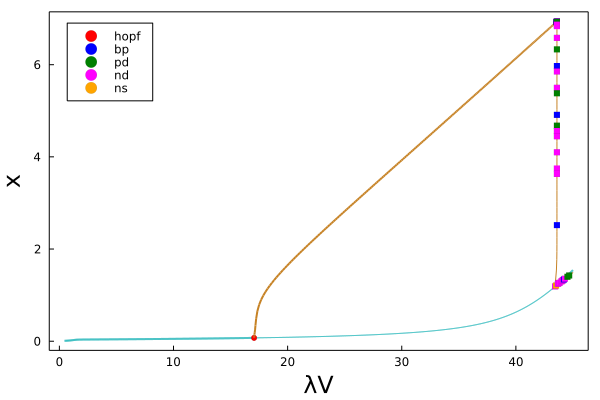

In [25]:
br_4 = continuation(get_bProb_λV(p_vals_4), PALC(tangent=Bordered()), opts_br_4; plot=false, normC=norminf);
@time br_po_4 = continuation(br_4, 1, opts_po_4, PeriodicOrbitTrapProblem(M=200, jacobian=:Dense, updateSectionEveryStep=1); verbosity=0, callback=BK.cbMaxNorm(10), plot=false, make_po_args_λV(p_vals_4)...).γ;
plot(br_4,br_po_4, legend=:topleft)

In [26]:
bps_4 = select_bps(br_4,[1,2])
starts_4 = [1,bps_4[1].idx,bps_4[2].idx]
ends_4 = [bps_4[1].idx,bps_4[2].idx,length(br_4.branch)]
branches_4 = split_branch(br_4,starts_4,ends_4);

plot(); 
plot_branch!(branches_4[1];lw=lw,la=la,color=:blue,linestyle=:solid)
plot_branch!(branches_4[2];lw=lw,la=la,color=:red,linestyle=:dot)
plot_branch!(branches_4[3];lw=lw,la=la,color=:blue,linestyle=:solid)

bps_po_4 = select_bps(br_po_4,[1,2,3])
starts_po_4 = [1,230]
ends_po_4 = [230,293]
branches_po_4 = split_branch(br_po_4,starts_po_4,ends_po_4);

plot_po!(branches_po_4[1];lw=lw,la=la,color=:purple,linestyle=:solid)
plot_po!(branches_po_4[2];lw=lw,la=la,color=:purple,linestyle=:dot)

plot_bp!(br_4, bps_4[1].idx, :red; ms=ms)
plot_bp!(br_4, bps_4[2].idx, :red; ms=ms)
plot_bp_po!(br_po_4, 230, :yellow; ms=ms)
bif_dia_4_plot = plot!(xlimit=(p_span_4[1],p_span_4[2]),yaxis=:log10)

idx = findfirst(getfield.(br_4.branch,:param) .> 4.5)
scatter!((br_4.branch[idx].param,br_4.branch[idx].x),markercolor=:lightgreen, markersize=starsize, markerstrokewidth=starstrokewidth, markershape=:star4,label="",ylimit=(1e-3,1e1));

#### Combined plot

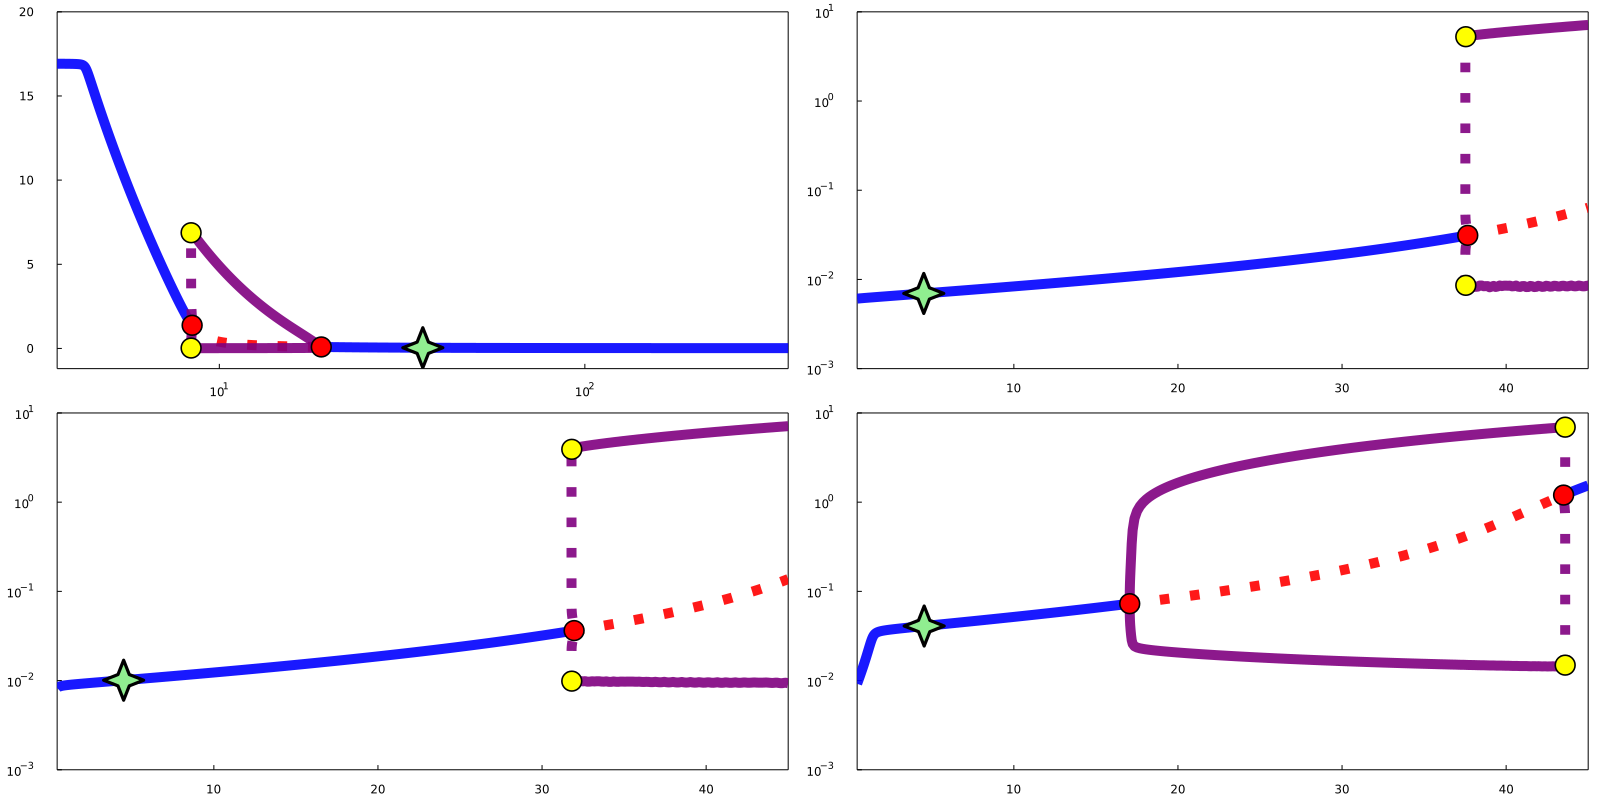

In [27]:
combined_bif_dias_plot = plot(bif_dia_1_plot,bif_dia_2_plot,bif_dia_3_plot,bif_dia_4_plot,size=(1600,800))

In [263]:
save_figure(plot!(combined_bif_dias_plot,xticks=[],yticks=[]), "Supplementary_Figures/Bifurcation_diagrams_periodic_orbits"; tag="bifs_", init="../Figures")

## New parameters model

In [221]:
function sigB_Model_NP!(dz, z, p, t)
    kBw, kDw, kD, kB1, kB2, kB3, kB4, kB5, kD1, kD2, kD3, kD4, kD5, kK1, kK2, pProd, kDeg, v0, F, K, λW, λV, pInit, pFrac, η = p
    w, w2, w2v, v, w2v2, vP, σB, w2σB, vPp, phos = z

    dz[1] = (v0*λW*(1 + F*σB)) / (K + σB) + 2kDw*w2 - kBw*(w^2) - kDeg*w
    dz[2] = kD1*w2v + kK1*w2v + kD3*w2σB + (1//2)*kBw*(w^2) - kDeg*w2 - kDw*w2 - kB1*v*w2 - kB3*w2*σB
    dz[3] = kD2*w2v2 + kK2*w2v2 + kB1*v*w2 + kB4*v*w2σB - kD1*w2v - kDeg*w2v - kK1*w2v - kB2*v*w2v - kD4*w2v*σB
    dz[4] = kD1*w2v + kD2*w2v2 + vPp*sqrt(pFrac*pProd) + (v0*λV*(1 + F*σB)) / (K + σB) + kD4*w2v*σB - kDeg*v - kB1*v*w2 - kB2*v*w2v - kB4*v*w2σB
    dz[5] = kB2*v*w2v - kD2*w2v2 - kDeg*w2v2 - kK2*w2v2
    dz[6] = kD5*vPp + kK1*w2v + kK2*w2v2 + vPp - kDeg*vP - kB5*phos*vP
    dz[7] = kD3*w2σB + (v0*(1 + F*σB)) / (K + σB) + kB4*v*w2σB - kDeg*σB - kB3*w2*σB - kD4*w2v*σB
    dz[8] = kB3*w2*σB + kD4*w2v*σB - kD3*w2σB - kDeg*w2σB - kB4*v*w2σB
    dz[9] = kB5*phos*vP - vPp - kD5*vPp - kDeg*vPp - vPp*sqrt(pFrac*pProd)
    dz[10] = sqrt(pProd / pFrac) + kD5*vPp + kDeg*vPp + vPp*sqrt(pFrac*pProd) - phos - kB5*phos*vP
    dz
end
sigB_Model_NP = (z, p) -> sigB_newpars_Model!(similar(z), z, p, 0);
p_syms_NP = [:kBw, :kDw, :kD, :kB1, :kB2, :kB3, :kB4, :kB5, :kD1, :kD2, :kD3, :kD4, :kD5, :kK1, :kK2, :pProd, :kDeg, :v0, :F, :K, :λW, :λV, :pInit, :pFrac, :η]
p_vals_org_NP = [3600.0, 18.0, 18.0, 3600.0, 3600.0, 3600.0, 1800.0, 3600.0, 18.0, 18.0, 18.0, 1800.0, 18.0, 36.0, 12.0, 60.0, 0.7, 0.4, 30.0, 0.2, 4.0, 4.5, 0.001, 100.0, 0.05];

In [222]:
get_p_idx_NP(p_sym) = findfirst(p_syms_NP .== p_sym)
function get_p_vals_NP(target_p,p_span,p_changes=[])
    p_vals = deepcopy(p_vals_org_NP)
    foreach(pc -> p_vals[get_p_idx_NP(pc[1])]=pc[2], [p_changes;target_p=>p_span[1]])
    return p_vals
end
get_pars_NP(p_vals) = (kBw=p_vals[1],kDw=p_vals[2],kD=p_vals[3],kB1=p_vals[4],kB2=p_vals[5],kB3=p_vals[6],kB4=p_vals[7],kB5=p_vals[8],kD1=p_vals[9],kD2=p_vals[10],kD3=p_vals[11],kD4=p_vals[12],kD5=p_vals[13],kK1=p_vals[14],kK2=p_vals[15],pProd=p_vals[16],kDeg=p_vals[17],v0=p_vals[18],F=p_vals[19],K=p_vals[20],λW=p_vals[21],λV=p_vals[22],pInit=p_vals[23],pFrac=p_vals[24],η=p_vals[25]);
get_z0_NP(p_vals) = solve(ODEProblem(sigB_Model_NP!,fill(1.0,10),(0.,50.0),p_vals), Rosenbrock23()).u[end];
get_bProb_pProd_NP(p_vals) = BifurcationProblem(sigB_Model_NP, get_z0_NP(p_vals), get_pars_NP(p_vals), (@lens _.pProd); recordFromSolution = (x, p) -> x[7]);

In [254]:
function make_po_args_NP(p_vals)
    pars = get_pars_NP(p_vals)
    return (recordFromSolution = (x, p) -> begin
        xtt = BK.getPeriodicOrbit(p.prob, x, @set pars.pProd = p.p)
        return (max = maximum(xtt[7,:]),
                min = minimum(xtt[7,:]),
                period = getPeriod(p.prob, x, @set pars.pProd = p.p))
    end,
    plotSolution = (x, p; k...) -> begin
            xtt = BK.getPeriodicOrbit(p.prob, x, @set pars.pProd = p.p)
            plot!(xtt.t, xtt.u[7,:]; label = "X", k...)
            plot!(br; subplot = 1, putspecialptlegend = false)
        end,
    normC = norminf);
end;

In [ ]:
ms = 11
lw = 11
la = 0.9;

#### Bifurcation diagram 2

In [293]:
p_span = (20.0,500.0);
p_vals = get_p_vals_NP(:pProd,p_span);

In [294]:
opts_br = ContinuationPar(pMin=p_span[1], pMax=p_span[2], ds=0.005, dsmax=0.05, maxSteps = 10000, detectBifurcation=3, nInversion=8, maxBisectionSteps=25, nev=4);
opts_po = ContinuationPar(pMin=p_span[1], pMax=p_span[2], dsmin=0.0025, ds=-0.1, dsmax=0.5, maxSteps=200, newtonOptions=(@set optn_po.tol=1e-8), nev=10, tolStability=1e-1, detectBifurcation=2, plotEveryStep=10, saveSolEveryStep=1);

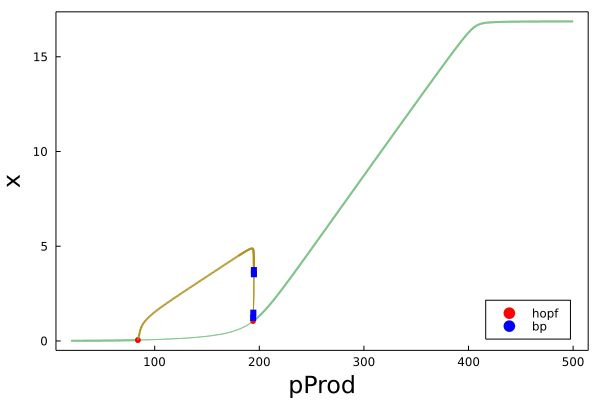

In [295]:
br = contopts_po = ContinuationPar(pMin=p_span[1], pMax=p_span[2], dsmin=0.0025, ds=-0.1, dsmax=0.5, maxSteps=200, newtonOptions=(@set optn_po.tol=1e-8), nev=10, tolStability=1e-1, detectBifurcation=2, plotEveryStep=10, saveSolEveryStep=1);inuation(get_bProb_pProd_NP(p_vals), PALC(tangent=Bordered()), opts_br; plot=false, normC=norminf);
br_po = continuation(br, 1, opts_po, PeriodicOrbitTrapProblem(M=200, jacobian=:Dense, updateSectionEveryStep=1); verbosity=0, callback=BK.cbMaxNorm(10), plot=false, make_po_args_NP(p_vals)...).γ;
plot(br,br_po, legend=:bottomright)

In [317]:
bps = select_bps(br,[1,2])
starts = [1,bps[1].idx,bps[2].idx]
ends = [bps[1].idx,bps[2].idx,length(br.branch)]
branches = split_branch(br,starts,ends);

plot(); 
plot_branch!(branches[1];lw=lw,la=la,color=:blue,linestyle=:solid)
plot_branch!(branches[2];lw=lw,la=la,color=:red,linestyle=:dot)
plot_branch!(branches[3];lw=lw,la=la,color=:blue,linestyle=:solid)

bps_po = select_bps(br_po,[1,2,3,4,5])
starts_po = [1,167]
ends_po = [167,171]
branches_po = split_branch(br_po,starts_po,ends_po);

plot_po!(branches_po[1];lw=lw,la=la,color=:purple,linestyle=:solid)
plot_po!(branches_po[2];lw=lw,la=la,color=:purple,linestyle=:dot)

plot_bp!(br, bps[1].idx, :red; ms=ms)
plot_bp!(br, bps[2].idx, :red; ms=ms)
plot_bp_po!(br_po, bps_po[1].idx, :yellow; ms=ms);

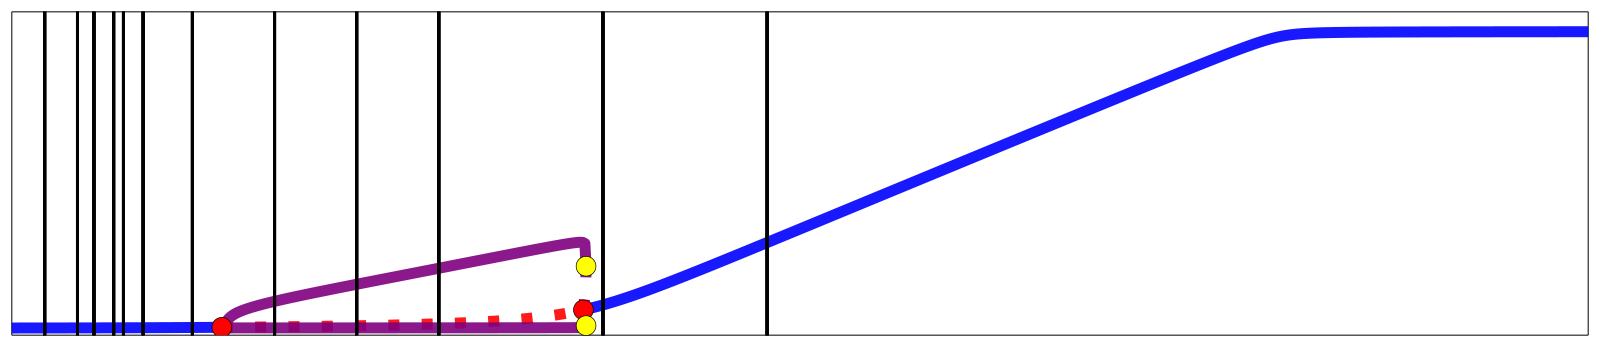

In [333]:
pProd_samples = [30.0,40.0,45.0,51.0,54.0,60.0,75.0,100.0,125.0,150.0,200.0,250.0]
foreach(pPrd -> plot!([pPrd,pPrd],[-1.,20.0],lw=3,color=:black,label="",la=0.6), pProd_samples)
bif_dia_plot = plot!(ylimit=(-0.4,18.0),la=0.3,xlimit=(p_span[1],p_span[2]),size=(1600,347),xticks=[],yticks=[])

In [334]:
save_figure(bif_dia_plot, "Behavioural_Change_With_Input/Additional_bifurcation_diagram"; tag="bif_", init="../Figures")